# Kaggle 월마트 상품 판매량 예측해보기

**Data source** : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

**Reference** : https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting

## 1. 라이브러리 및 데이터 로드

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

In [3]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv.zip')
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv.zip')
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission = pd.read_csv('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

## 2. Exploratory Data Analysis(EDA) & Data Cleansing

### feature.csv 데이터셋과 stores.csv 데이터셋을 merge해서 새로운 데이터셋(feat_sto)을 만듭니다. 이때 'Store' 컬럼을 키로 사용합니다.

In [4]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [5]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
feat_sto.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

> 'Date' 필드가 string(object) 타입으로 지정되어 있는 모습을 볼 수 있습니다. 우리는 이를 datetime 타입으로 변경할 수 있습니다.

In [7]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [9]:
test.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [10]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

### 'Date'로부터 Week와 Year 컬럼을 새로 추가합니다.

In [11]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

<ipython-input-11-0cdbe1a1e629>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  feat_sto['Week'] = feat_sto.Date.dt.week


In [12]:
feat_sto

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221,26,2013
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221,27,2013
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221,28,2013
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221,29,2013


### train과 feat_sto, test와 feat_sto를 묶어서 train_detail, test_detail이라는 새로운 데이터 프레임을 생성합니다.

In [13]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [14]:
test_detail = test.merge(feat_sto, 
                         how='inner',
                         on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                          'Dept',
                                                                          'Date']).reset_index(drop=True)

In [15]:
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,2012


### 연도별 날짜별 판매량을 그래프로 살펴봅시다.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


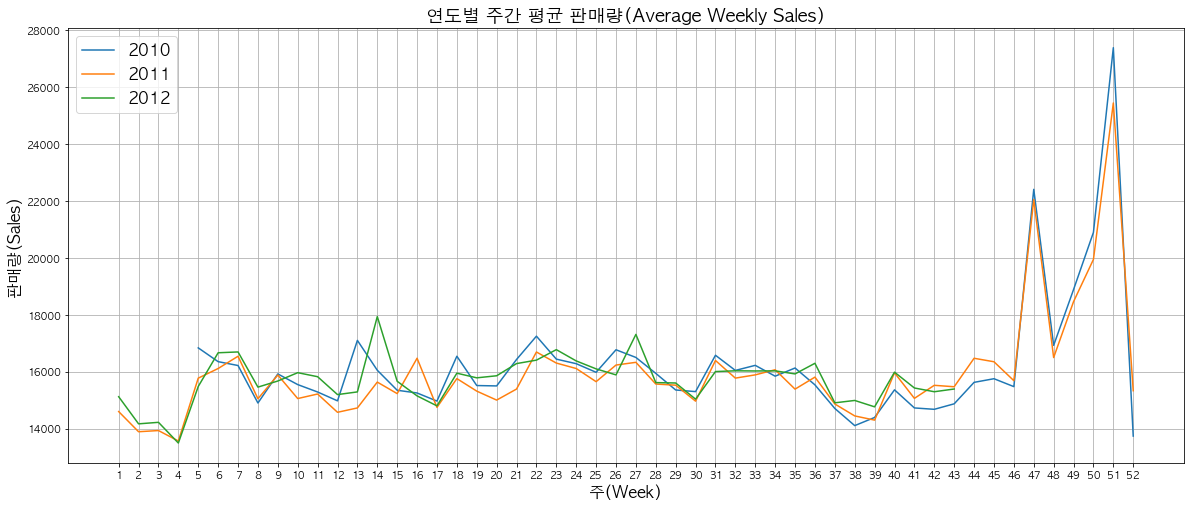

In [16]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('연도별 주간 평균 판매량(Average Weekly Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('주(Week)', fontsize=16)
plt.show()

# 날짜별 판매량 평균값(Mean)과 중앙값(Median) 구해보기

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


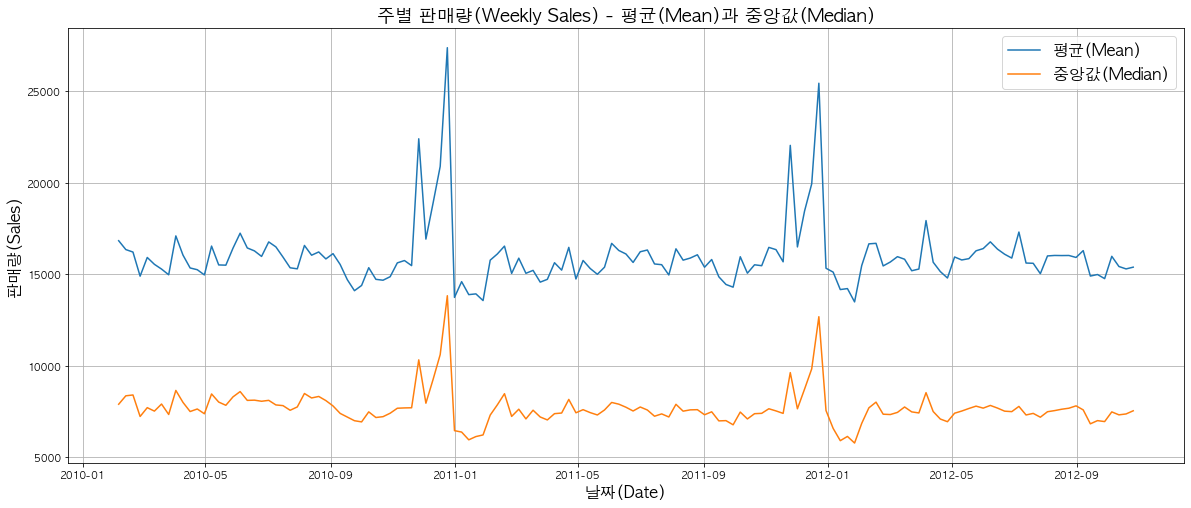

In [17]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['평균(Mean)', '중앙값(Median)'], loc='best', fontsize=16)
plt.title('주별 판매량(Weekly Sales) - 평균(Mean)과 중앙값(Median)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('날짜(Date)', fontsize=16)
plt.show()

#### 위에서 볼 수 있듯이 평균값(mean)과 중앙값(median)이 매우 다른 모습을 볼 수 있습니다. 따라서 어떤 상점(store)/부서(department)는 다른 상점보다 훨씬 많이 판매한다는 사실을 알 수 있습니다.

## 상점(Store)와 부서(Department)별 평균 판매량(Average Sales)을 살펴봅시다.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


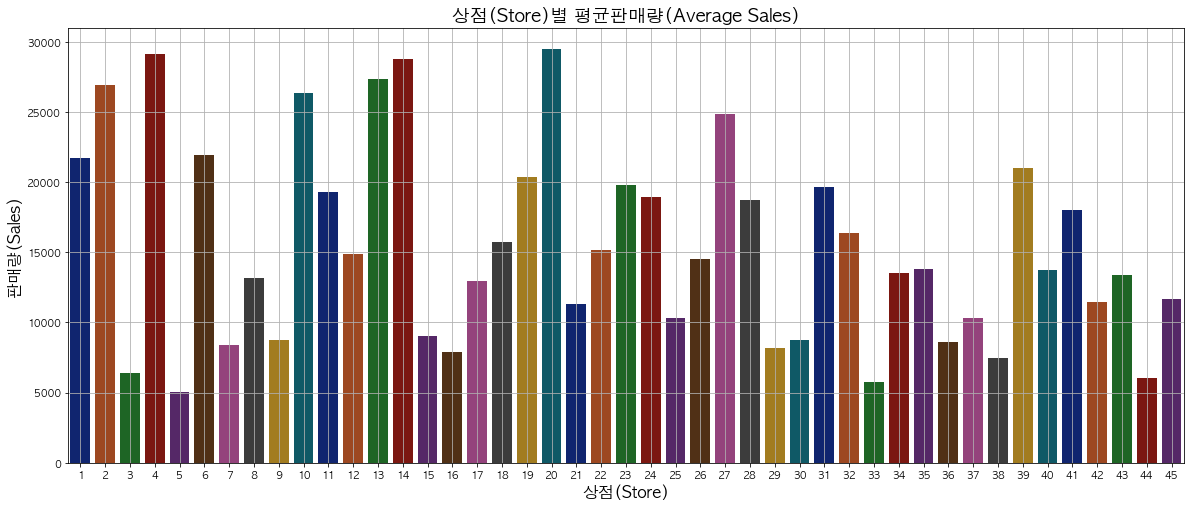

In [18]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('상점(Store)별 평균판매량(Average Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('상점(Store)', fontsize=16)
plt.show()

## 상점별로 판매량이 다른 모습을 볼 수 있습니다.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


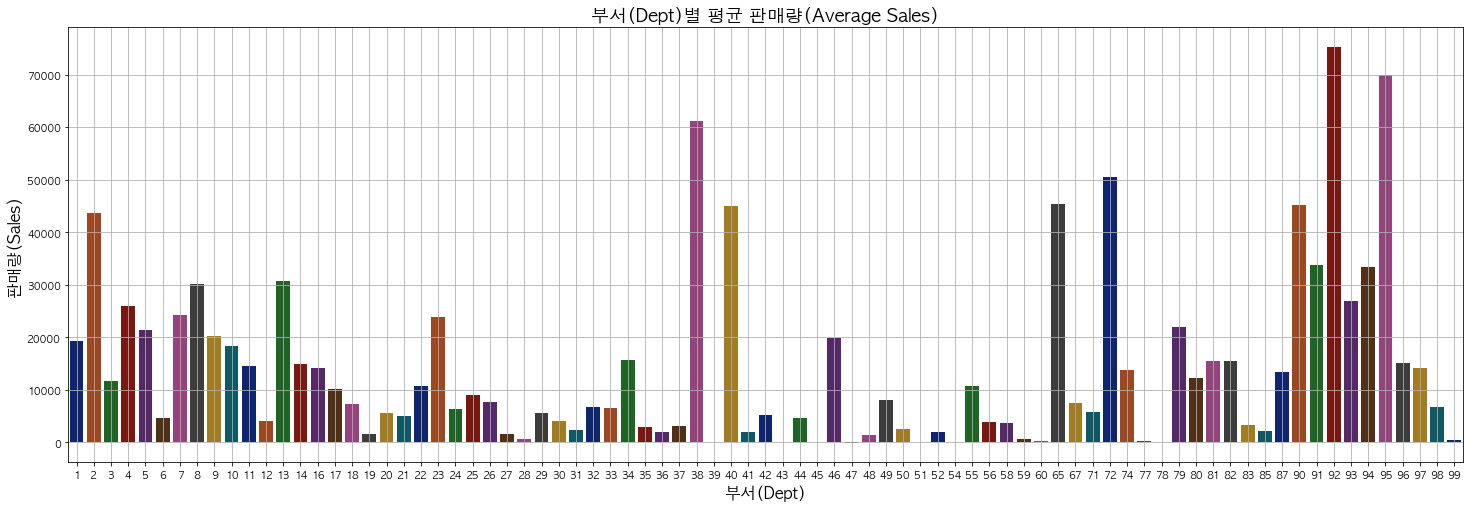

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('부서(Dept)별 평균 판매량(Average Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('부서(Dept)', fontsize=16)
plt.show()

### 또한 부서(Dept)별로 판매량이 다른 모습을 관찰할 수 있습니다.

## 상관 분석(Correlation Analysis) 수행해보기

### 일반적으로 Correlation을 다음과 같이 해석합니다.
1. **0** : 전혀 연관관계가 없습니다.
2. **0-0.3** : 약간 연관관계를 갖고 있습니다.
3. **0.3-0.7** : 중간정도의 연관관계를 갖고 있습니다.
4. **0.7-1** : 강한 상관관계를 갖고 있습니다.

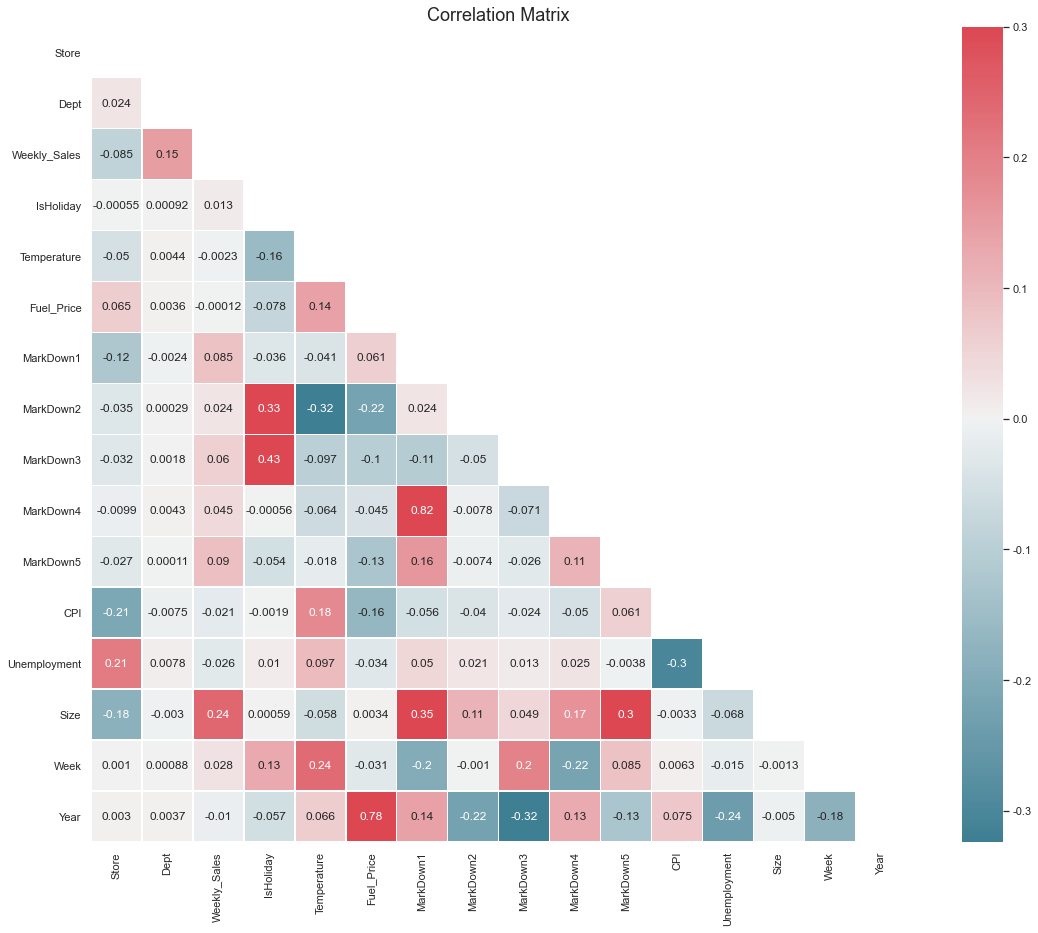

In [20]:
sns.set(style="white")
corr = train_detail.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

### Markdown1~5과 Fuel_price는 주간 판매량(Weekly_Sales)와 큰 연관관계가 없는 모습을 볼 수 있습니다. 따라서 해당 Feature는 드롭합니다.

In [21]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

## Feature 더 자세히 분석하기

### 두가지 plot 함수를 만들어봅시다.
### 먼저 제한된 숫자를 가진 컬럼을 위한 discrete plot을 그립니다. discrete plot 같은 경우, boxplot과 stripplot을 이용해서 그래프를 그립니다.
### 연속된 값을 가진 컬럼을 위한 continuous plot을 그립니다.  cotinuous plot 같은 경우, scatterplot 이용해서 그래프를 그립니다.

In [22]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y = train_detail.Weekly_Sales, x = train_detail[feature], ax = fig.add_subplot(gs[0,0]))
    plt.ylabel('판매량(Sales)', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('판매량(Sales)', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [23]:
def make_continuous_plot(feature):    
    fig = plt.figure(figsize=(18,15))
    sns.scatterplot(data=train_detail, x=feature, y='Weekly_Sales', color='green')
    fig.show()

### Weekly_Sales 컬럼과 IsHoliday 컬럼의 상관관계 분석

<ipython-input-22-35aebe3cd8db>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54032 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47588 mis

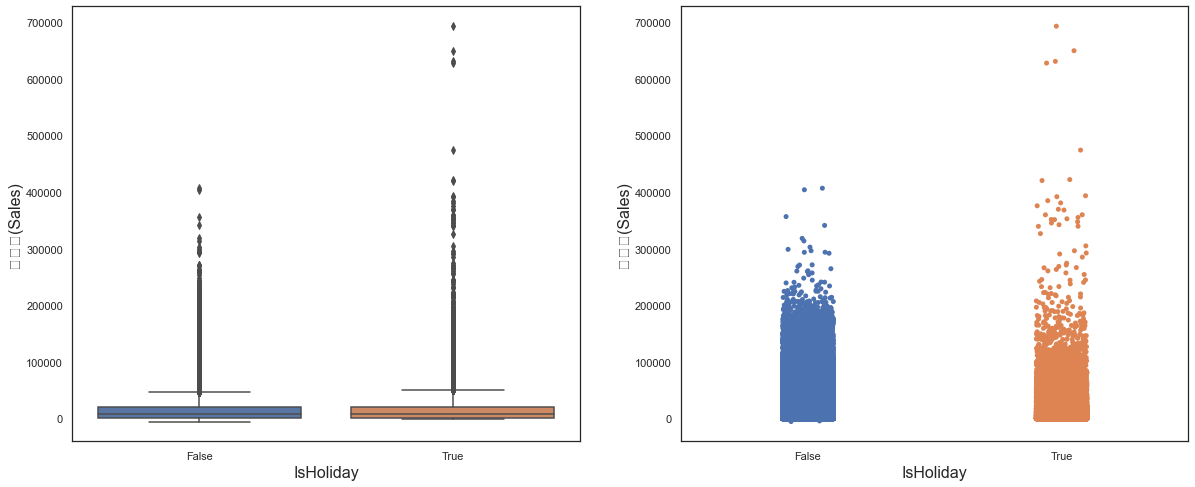

In [24]:
make_discrete_plot('IsHoliday')

### 공휴일 주간에 더욱 많은 판매량을 기록한 데이터들이 존재하는 모습을 볼 수 있습니다.

### Weekly_Sales 컬럼과 Type 컬럼의 상관관계 분석

<ipython-input-22-35aebe3cd8db>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54032 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47588 mis

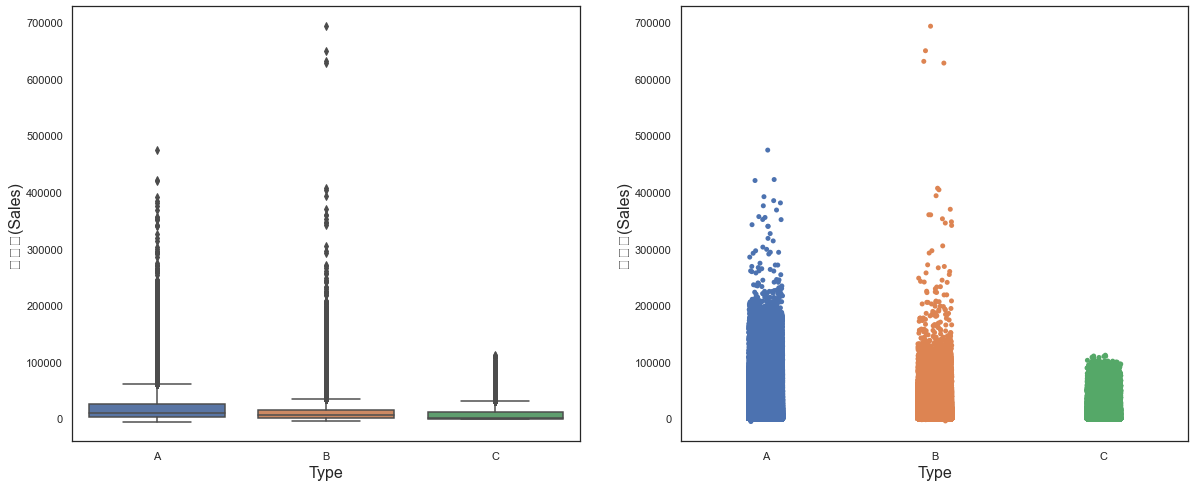

In [25]:
make_discrete_plot('Type')

## Type의 A > B > C 순으로 판매량이 많은 모습을 볼 수 있습니다.

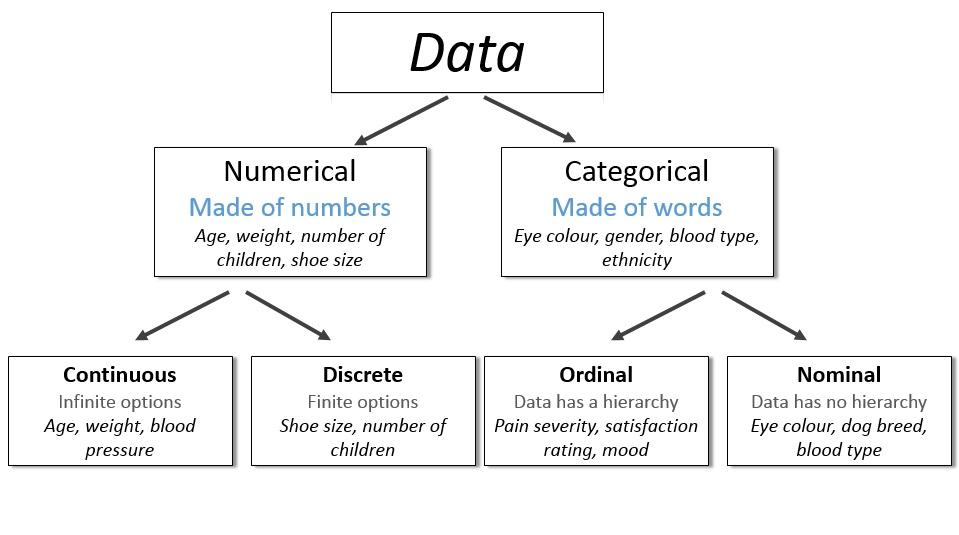

## 따라서 Type 컬럼을 Ordinal 형태로 변경합니다.

In [26]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Weekly_Sales 컬럼과 Temperature 컬럼의 상관관계 분석

<ipython-input-23-7a664a5a1ed9>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


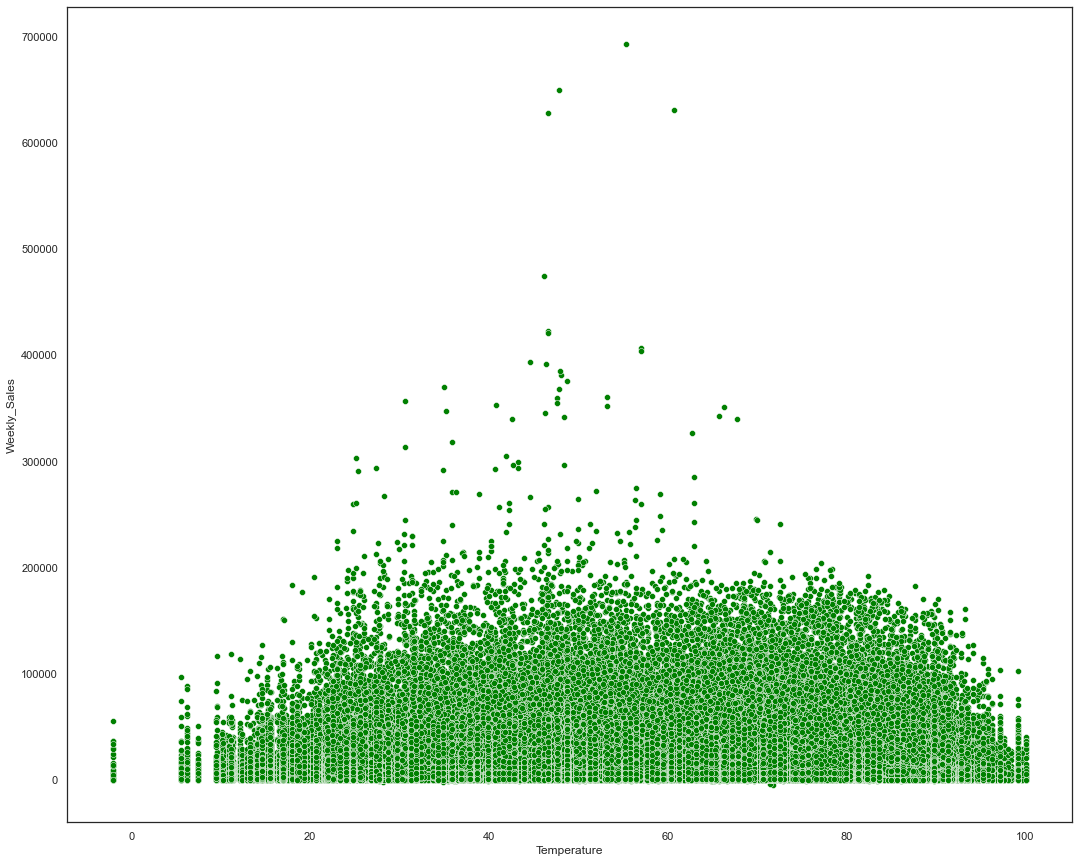

In [27]:
make_continuous_plot('Temperature')

## Temperatue는 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [28]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales 컬럼과 CPI 컬럼의 상관관계 분석

<ipython-input-23-7a664a5a1ed9>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


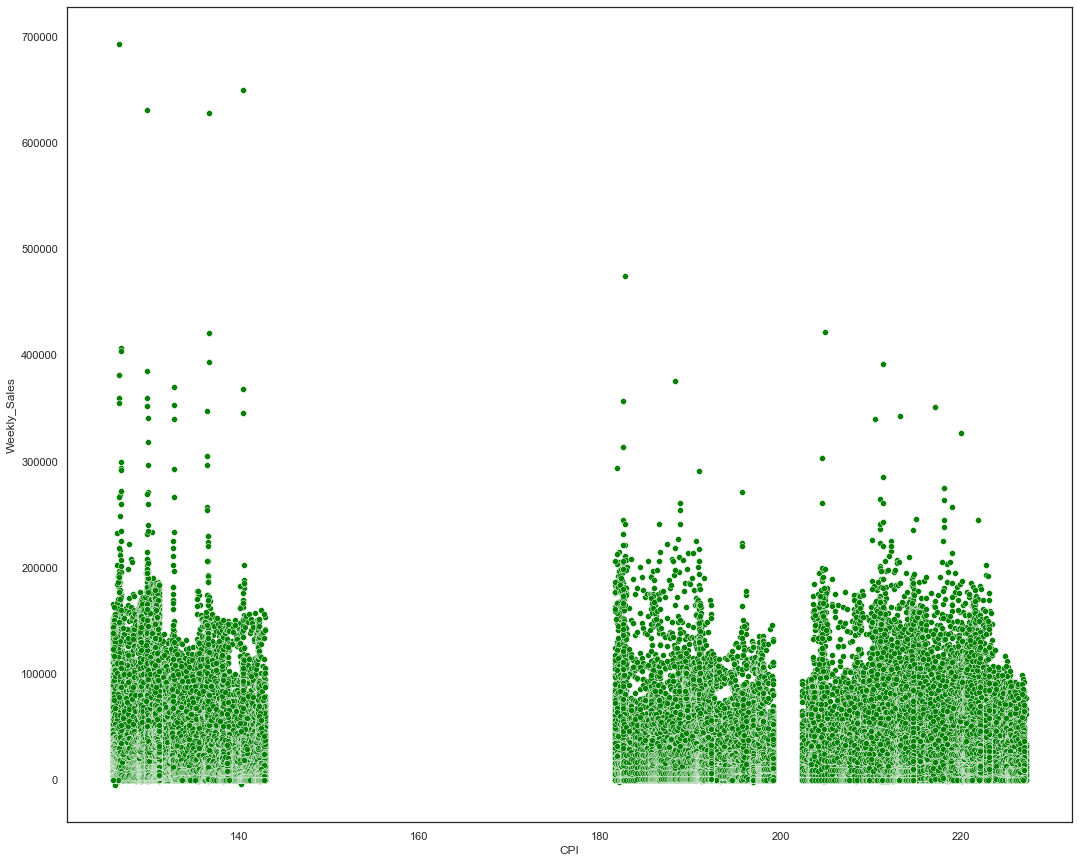

In [29]:
make_continuous_plot('CPI')

## CPI 또한 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [30]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly_Sales 컬럼과 Unemployment 컬럼의 상관관계 분석

<ipython-input-23-7a664a5a1ed9>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


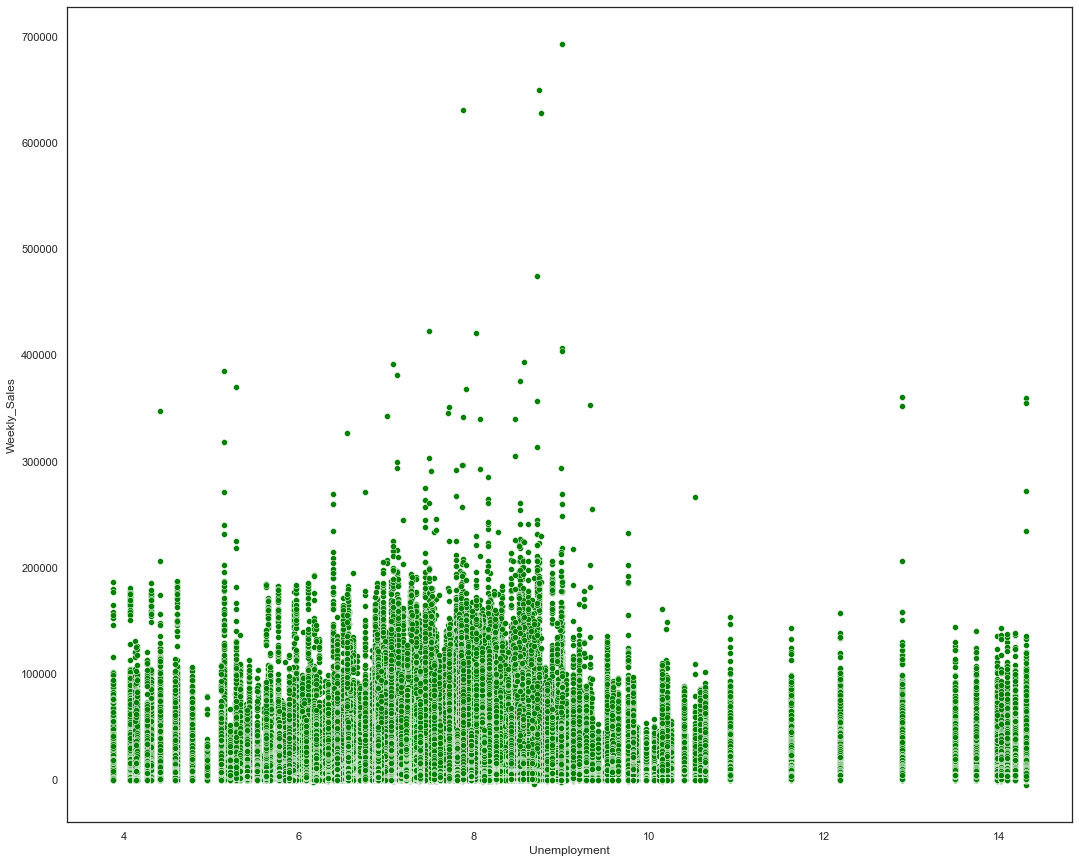

In [31]:
make_continuous_plot('Unemployment')

## Unemployment 또한 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [32]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

### Weekly_Sales 컬럼과 Size 컬럼의 상관관계 분석

<ipython-input-23-7a664a5a1ed9>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


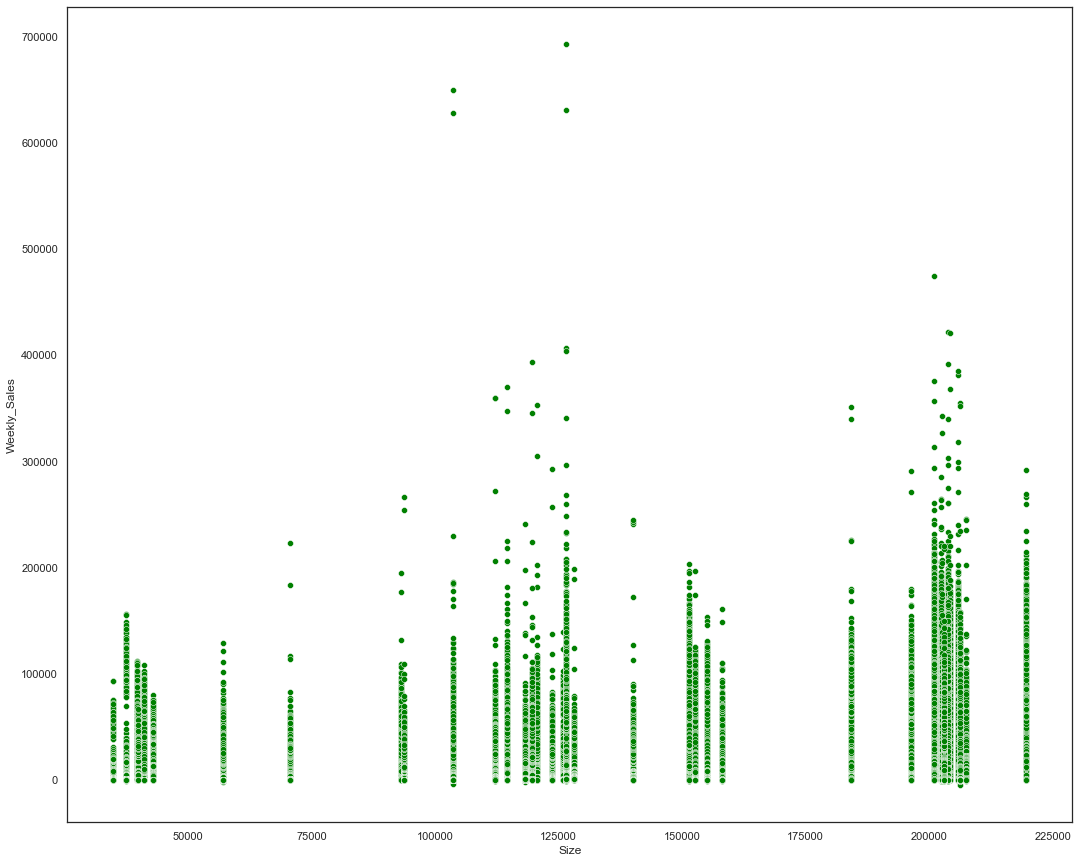

In [33]:
make_continuous_plot('Size')

## Size는 판매량과 연관관계를 가지고 있는 모습을 볼 수 있습니다.

# 3. 머신러닝을 이용한 예측 모델 생성

> 아래 그림에서 볼 수 있듯이 공휴일이 포함된 주에 5의 가중치를 가지고 에러를 측정합니다.

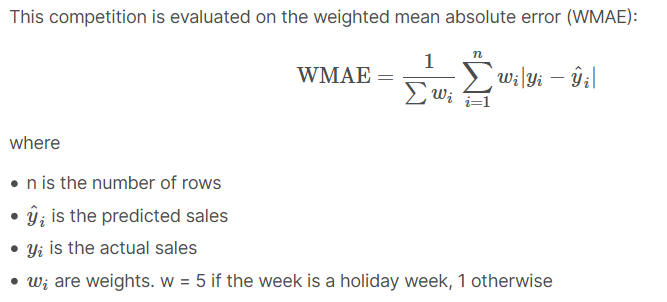

## 따라서 WMAE 손실함수를 다음과 같이 정의합니다.

In [34]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## 분류기로 RandomForesRegressor를 활용합니다. 

## 트레이닝 데이터를 준비합니다.

In [35]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,3,151315,5,2010
1,1,1,2010-02-12,46039.49,True,3,151315,6,2010
2,1,1,2010-02-19,41595.55,False,3,151315,7,2010
3,1,1,2010-02-26,19403.54,False,3,151315,8,2010
4,1,1,2010-03-05,21827.90,False,3,151315,9,2010


In [36]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

## Random Forest Estimator를 선언하고 학습 및 예측을 진행합니다.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
RF = RandomForestRegressor()
RF.fit(x_train, y_train)
predicted = RF.predict(x_test)

## 트레이닝 에러를 측정합니다.

In [38]:
print('WMAE :', WMAE(x_test, y_test, predicted))

WMAE : 1471.01


### 테스트 데이터에 대한 예측 수행하기(Predictions)

In [39]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

# 4. 대회제출용 csv 데이터 만들기(Submission)

In [40]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [41]:
sample_submission['Weekly_Sales'] = predict
sample_submission.to_csv('submission.csv',index=False)

In [42]:
sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,31987.9477
1,1_1_2012-11-09,19166.6088
2,1_1_2012-11-16,19315.2600
3,1_1_2012-11-23,21111.9375
4,1_1_2012-11-30,24726.9211
...,...,...
115059,45_98_2013-06-28,659.6697
115060,45_98_2013-07-05,672.7171
115061,45_98_2013-07-12,685.0824
115062,45_98_2013-07-19,773.6852


#### 작성자 : AISchool ( http://aischool.ai/ )